In [1]:
import os, sys, collections, re, json, io, base64
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as smapi
import statsmodels.tsa.stattools as ts
import warnings
import scipy
import IPython
import sklearn

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML
from pandas import Series
from IPython.display import display, Math, Latex
from IPython.external import mathjax
from scipy import stats
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas import Series

plt.style.use('ggplot')
plt.rc("savefig", dpi=110)

<H1 align="center"> Inventarios de Crudo: <br> <br> Un Indicador del precio del Crudo WTI </center></H1> <br> <br><br> 

<center> Roque Leal </center> 
<center> Email: roqueleal@gmail.com </center>   
<center>DataScience en Oil & Gas</center> <br> 

### Abstract
Este Jupyter Notebook propone un modelo de pronóstico a largo plazo del precio spot del petróleo crudo West Texas Intermediate (WTI) utilizando el nivel de inventario de petróleo de Estados Unidos. Los datos de inventario utilizados en el modelo se actualizan cada miércoles a las 10:30 AM EST, lo que da como resultado un nuevo valor pronosticado para cada informe. Al aplicar el modelo de pronóstico entre enero de 2010 y la fecha, encuentro que el modelo ofrece un rendimiento persistente a largo plazo. El modelo es útil para aquellos que estén interesados ​​en pronosticar los precios futuros del petróleo o para aquellos que deseen comprender e interpretar fluctuaciones históricas de precios.
### Objetivo
 El objetivo es proporcionar un modelo de pronóstico simple y práctico que se pueda implementar fácilmente. Para probar el poder predictivo del modelo, empleé pronósticos fuera de muestra. El resultado sugiere que el nivel de inventario de petróleo ha sido un indicador líder del precio spot del crudo en la última década.
### Hipótesis
Intuitivamente, debería haber una relación negativa entre el nivel de inventario de petróleo y el precio del petróleo. La razón es que un cambio en el inventario de petróleo puede interpretarse como el resultado del desequilibrio entre el suministro y la demanda, por lo tanto debería afectar el precio spot de manera inversa. En la práctica, la relación entre el inventario de petróleo y el precio del petróleo no son directamente obvios; para citar un ejemplo el nivel de inventario de petróleo se ve afectado por movimientos estacionales.
De modo que diría que el nivel de inventario relativo es un indicador que normaliza, por ejemplo, cualquier tendencia temporal determinista y variación estacional en la producción, consumo y refinería. El concepto central es que si los inventarios actuales se desvían de su nivel normal, de acuerdo con la tendencia del inventario y los cambios estacionales, el mercado está en desequilibrio y los precios deberían reaccionar en consecuencia. El nivel de inventario relativo que llamaré RIN, se define como la desviación del nivel de inventario de petróleo observado, siendo IN un nivel normal históricamente determinado. Igualmente utilizaré una variable temporal que llamaré D, para extraer el efecto estacional del nivel de inventario observado.



Los inventarios observados son desestacionalizados a través de la siguiente regresión.

$$  ln{(IN_t)} = \alpha_o + \sum_{k=2}^{n}\beta_k D_k + \epsilon_t \tag{1} $$

$$ ln{\widehat{(IN_t)}} = \alpha_o + \sum_{k=2}^{n}\beta_k D_k \tag{2} $$

Una vez que se estiman los parámetros ficticios, se puede extraer la influencia estacional del nivel de inventario, donde
los residuos resultantes representarán el nivel de inventario relativo.

$$ ln{(RIN_t)} = ln{(IN_t)} - ln{(\widehat{IN}_t)}  \tag{3} $$

In [6]:
# EIA Inventory Data (df)
dfInventory = pd.read_excel('http://ir.eia.gov/wpsr/psw01.xls', "Data 1", index_col="Date", parse_dates=["Date"], skiprows=2)

# Historical Spot Price (df3)
dfSpot = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_W.xls', "Data 1", parse_dates=["Date"], index_col="Date", skiprows=[0,1])

# Intrada Spot Price (Df5)
dfIntraSpot = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', "Data 1", parse_dates=["Date"], index_col="Date", skiprows=[0,1])

# Subset
dfInventory = dfInventory["2010":"2050"]
dfSpot = dfSpot["2010":"2050"]
dfIntraSpot = dfIntraSpot["2010":"2050"]

# Create seasonal dummies
dfDummies = pd.get_dummies(dfInventory.index.week)
dfDummies.index = dfInventory.index
dfInventory = pd.concat([dfInventory, dfDummies], axis= 1)                          
                          
# Rename cols
dfInventory_cols = ['crude_oil','crude_oil_no_spr','crude_in_spr','gasoline','reformulated_gasoline','conventional_gasoline','blending_gasoline','fuel_ethanol','jet_fuel','distillate', 'distillate_15ppm','distillate_500ppm','distillate_500+ppm','residual_oil','propane_propylene','other_oils','unfinished_oils','Inventory','crude_products_no_spr', 'W1','W2', 'W3', 'W4', 'W5', 'W6', 'W7','W8','W9' ,'W10' ,'W11' ,'W12' ,'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'W29', 'W30', 'W31', 'W32', 'W33', 'W34', 'W35', 'W36', 'W37', 'W38', 'W39', 'W40', 'W41', 'W42', 'W43', 'W44', 'W45', 'W46', 'W47', 'W48', 'W49', 'W50', 'W51', 'W52', 'W53']
dfInventory.columns = dfInventory_cols                          

dfSpot_cols = ['WTI', 'Brent']
dfSpot.columns = dfSpot_cols

dfIntraSpot_cols = ['WTI_daily', 'Brent_daily']
dfIntraSpot.columns = dfIntraSpot_cols 

In [7]:
# Log Transformation
dfInventory['IP_log']= np.log(dfInventory.Inventory)

# Linear Regression
m1 = smapi.OLS.from_formula('IP_log ~ W1 +W2+ W3+ W4+ W5+ W6+ W7+ W8+ W9+ W10+ W11+ W12+ W13+ W14+ W15+ W16+ W17+ W18+ W19+ W20+ W21+ W22+ W23+ W24+ W25+ W26+ W27+ W28+ W29+ W30+ W31+ W32+ W33+ W34+ W35+ W36+ W37+ W38+ W39+ W40+ W41+ W42+ W43+ W44+ W45+ W46+ W47+ W48+ W49+ W50+ W51+ W52+ W53 -1', dfInventory).fit()

# Predict Residuals
dfInventory['RIN'] = m1.resid

# Concat Inventory Data with Weekly Spot Price 
df = pd.concat([dfInventory, dfSpot], axis= 1)

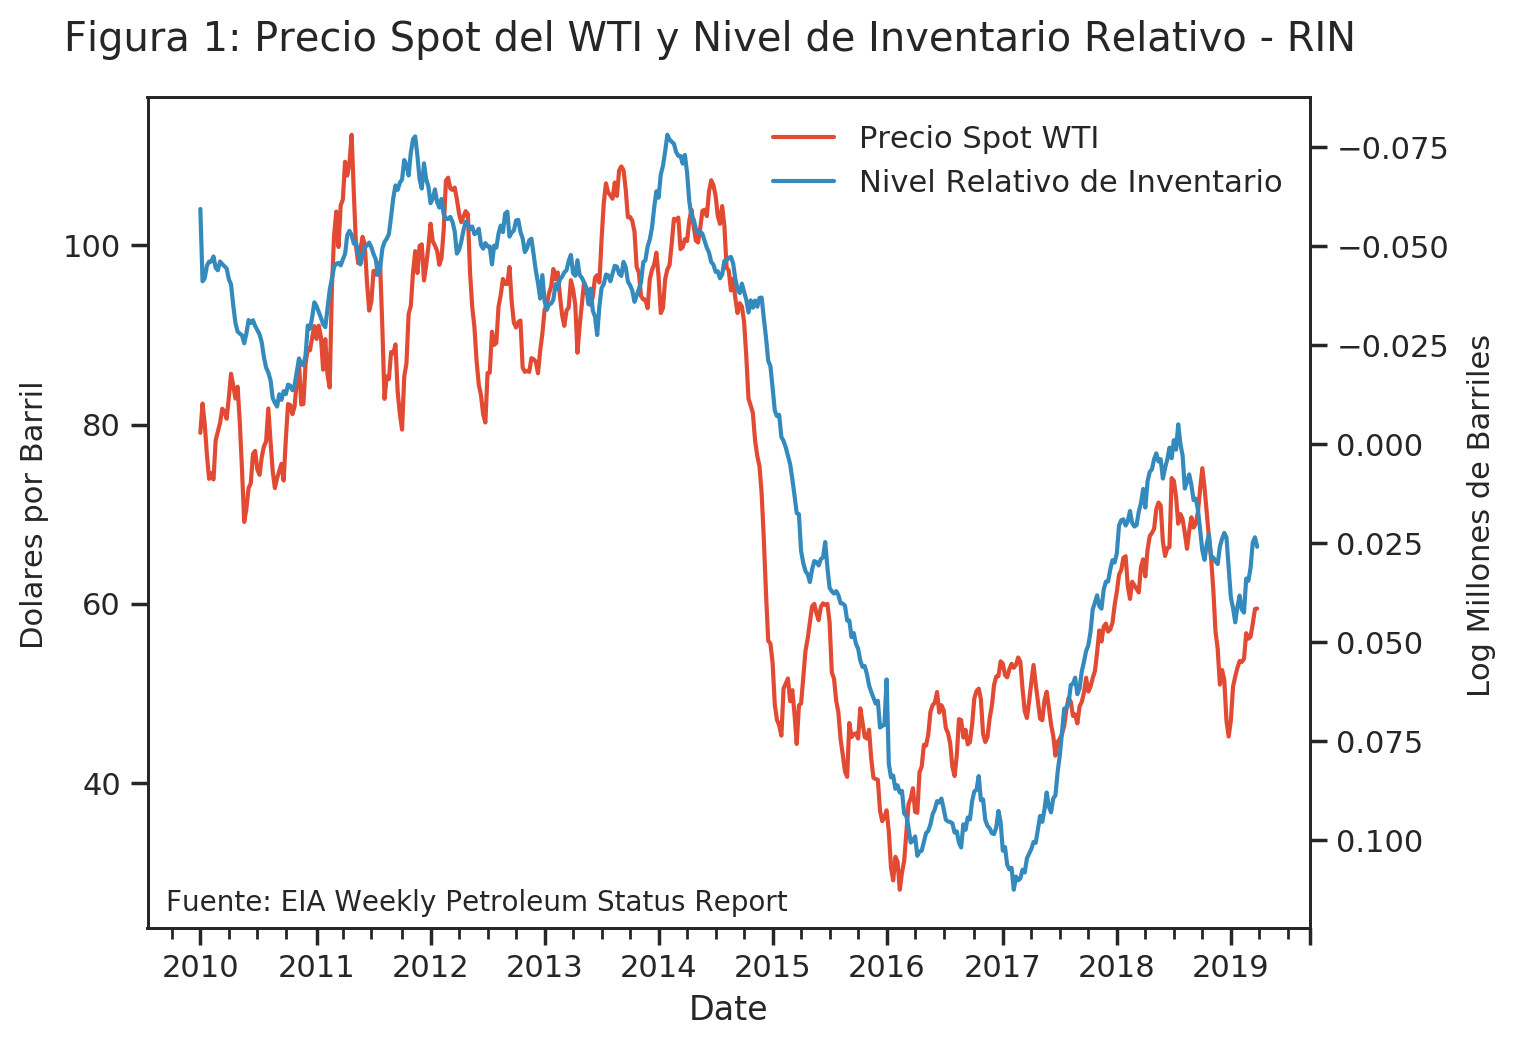

PearsonR Correlation Coefficient: -0.902 (WTI & RIN)


In [9]:
sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=100)
ax1 = df['WTI'].plot(label='Precio Spot WTI')
ax2 = df['RIN'].plot(secondary_y=True, label='Nivel Relativo de Inventario')
ax2 = plt.gca()
ax2.invert_yaxis()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=1, frameon=False)
plt.figtext(0.137, 0.14, "Fuente: EIA Weekly Petroleum Status Report", fontsize= 10)
plt.suptitle('Figura 1: Precio Spot del WTI y Nivel de Inventario Relativo - RIN', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.04, 0.5, 'Dolares por Barril', va='center', rotation='vertical', fontsize=11)
plt.figtext(1.005, 0.5, 'Log Millones de Barriles', va='center', rotation='vertical', fontsize=11)
plt.style.use('ggplot')
plt.show()
corr = df['WTI'].corr(df['RIN'])
print('PearsonR Correlation Coefficient:',round(corr, 3),'(WTI & RIN)') 

In [10]:
# Square relative inventory
df['RINsqr']= df['RIN']**2

# Predict forecast
m2 = smapi.OLS.from_formula('WTI ~ RIN + RINsqr', df).fit()
df['Forecast'] = m2.fittedvalues

# Create year variable to hue by year
df.reset_index(inplace=True)
df['Year'] = df['Date'].dt.year
df.set_index('Date', inplace=True)
df.ix[-1,'Year'] = 'Latest Week'

# Substitue "Latest Week" observation to intraday spot price
df.ix[-1,'WTI'] = dfIntraSpot.ix[-1,'WTI_daily']

##### No correlación lineal entre el inventario relativo y el precio WTI Spot

La Figura 1, nos muestra que un nivel de operación mínimo de inventario es esencial para mantener en funcionamiento del sistema de suministro de América del Norte; los sistemas de tuberías necesitan un nivel de inventario amortiguado para mantener el sistema en funcionamiento, los camiones cisterna y los vagones necesitan combustible para enlazar los sitios de producción, y las terminales y refinerías necesitan un nivel básico para operar. Debido a que la economía requiere un nivel operativo mínimo de inventarios de petróleo, la relación entre el nivel de inventario y el precio al contado es intrínsecamente no lineal. Es decir, si el nivel de inventario se acercara a su nivel operativo mínimo, los precios en teoría deberían reaccionar de manera no lineal (aumentar exponencialmente) para compensar el riesgo asociado con una falta de existencias. Los inventarios de petróleo también pueden considerarse limitados debido a las limitaciones de infraestructura. Una vez que el excedente del inventario rompe la capacidad logística y de almacenamiento de reserva, los precios del petróleo deberían converger a un costo marginal y obligar a los productores a dejar de producir. POr ejemplo, los pozos de esquisto de EE.UU. pueden tener un costo variable de producción inferior a 15 dólares por barril, lo que hace que sus propietarios sigan produciendo incluso si los precios al contado están por debajo del costo promedio de los productores, de ser así es necesario graficar este escenario.

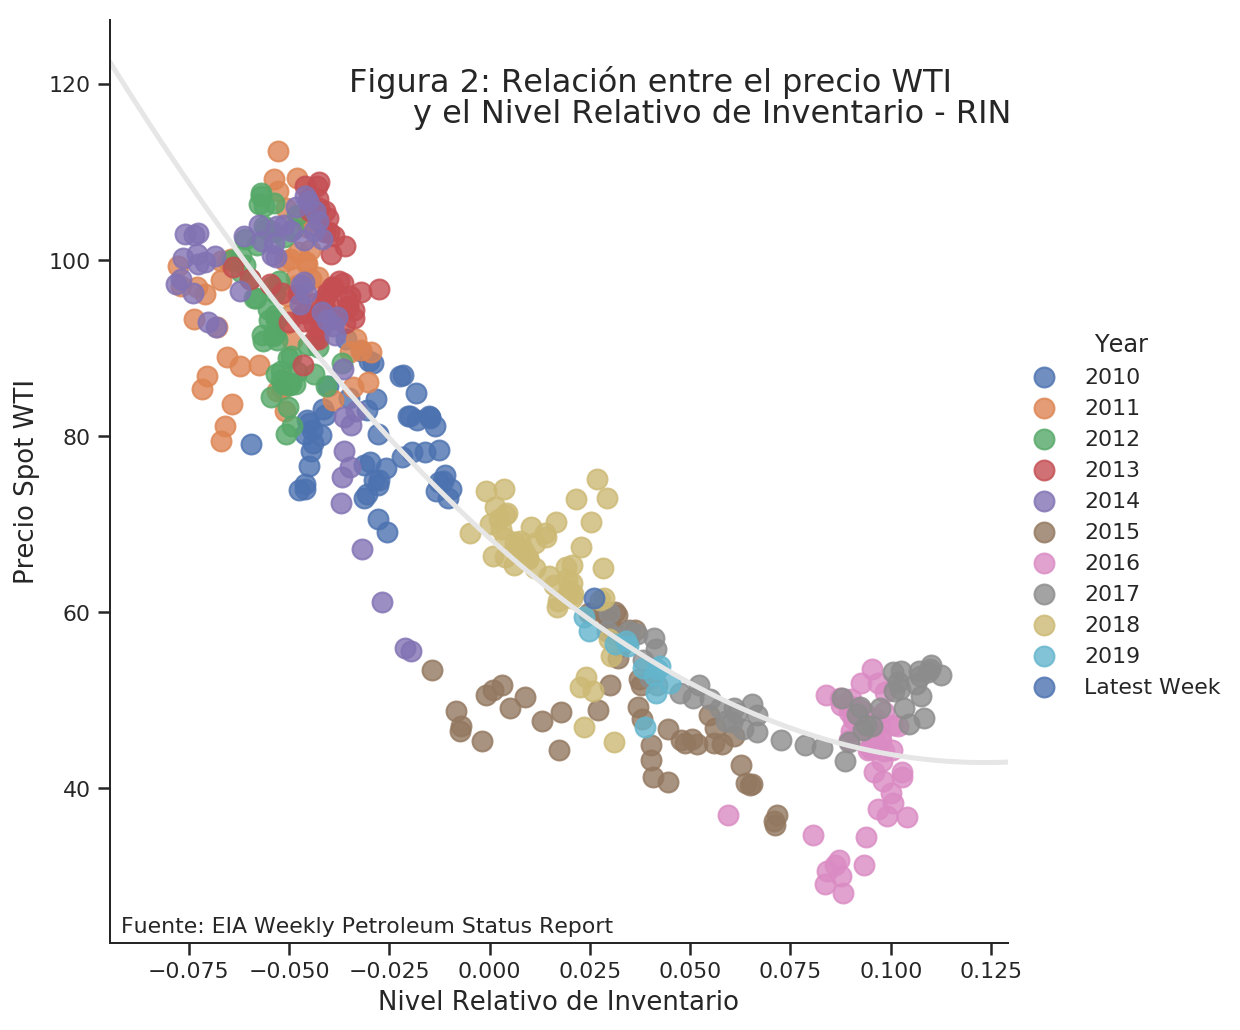

PearsonR Correlation Coefficient: 0.921 (WTI & Fitted line)
R2, Coefficient of Determination: 0.847


In [26]:
sns.set_style("white")
sns.set_style("ticks")
plot1 = sns.lmplot(x="RIN", y="WTI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="deep",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("RIN", "WTI", data=df, color=".9", scatter=False, order=2, ci=None, line_kws={"lw":2.5});

csfont = {'fontname':'Times New Roman'}

plt.figtext(0.12, 0.10, "Fuente: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Figura 2: Relación entre el precio WTI", fontsize= 16)
plt.figtext(0.35, 0.87, "y el Nivel Relativo de Inventario - RIN", fontsize= 16)
plt.xlabel("Nivel Relativo de Inventario", fontsize = 13)
plt.ylabel('Precio Spot WTI', fontsize = 13)
plt.show()

corr = df['Forecast'].corr(df['WTI'])
r2 = corr * corr

print('PearsonR Correlation Coefficient:',round(corr, 3),'(WTI & Fitted line)')
print('R2, Coefficient of Determination:',round(r2, 3))
# plt.savefig('plot_name.png', dpi = 1000)

La Figura 2 anterior, muestra la relación no lineal entre el precio spot del WTI y el Nivel de Inventario Relativo. En el eje vertical, el precio al contado del WTI se muestra en dólares estadounidenses por barril y en el eje horizontal, el Nivel de Inventario Relativo de los EE.UU. se muestra en escala logarítmica natural. La línea gris ajustada es equivalente al modelo de pronóstico a largo plazo. El límite superior e inferior de los inventarios de petróleo, creado por las restricciones de infraestructura y el nivel de operación mínimo, contribuye con una curvatura más pronunciada en los puntos extremos. En esencia, el mercado reconoce si el nivel de almacenamiento prevaleciente es sostenible o no y ajusta el precio WTI en consecuencia. El precio es, pues, el mecanismo que emplea el mercado para asegurar un suministro adecuado y para desalentar el mantenimiento del suministro excedente.

### Modelo

En esta sección, presentare el Modelo de Inventario Relativo que usaré para predecir el precio del petróleo. El modelo se basa en la noción de que el precio está determinado por el equilibrio entre la oferta y la demanda en el mercado físico. El propósito del pronóstico no es predecir cambios a corto plazo en el lugar, sino para separar el ruido a corto plazo al pronóstico a largo plazo. Al crear un modelo de pronóstico a corto plazo pienso que un modelo ARIMA sería más apropiado.

En la ecuación se estima lo siguiente:

$$ WTI_t = \alpha_o + \beta_1 RIN_{t-1} + \beta_1 {RIN^2}_{t-1} + \mu_t \tag{4} $$ 

Donde WTI es el promedio del precio al contado de WTI en el momento t y RIN es el Nivel de Inventario Relativo por período
antes. Paralelamente se agrega una variable al cuadrado del nivel de inventario relativo para reflejar la dinámica no lineal entre los precios del petróleo y los inventarios de crudo.

### Datos

Una base de datos que cubre el inventario de petróleo es un requisito previo para este modelo. La Agencia Internacional de Energía (IEA)
y la Administración de Información de Energía (EIA) de EE. UU. proporciona los datos más completos en términos de calidad, usaré el Informe de estado semanal del petróleo de EIA, este Dataset se publica semanalmente y cubre Inventarios estadounidenses de petróleo por la Administración de Petróleo para el Distrito de Defensa (PADD). Elegí limitar el Datos a los Estados Unidos, ya que supongo que el nivel de inventario de EE. UU. se ha convertido en la región más imperativa en su poder predictivo del precio spot del WTI.

El nivel de inventario de petróleo representa la cantidad de inventario de petróleo crudo y productos petrolíferos mantenidos en Inventario para uso futuro. Los inventarios se contabilizan según el territorio nacional, dentro de los límites geográficos de un país.
Región e independientemente de la propiedad. Dado que los inventarios se mantienen en el territorio nacional, no importa si los inventarios se mantienen en tierra, en alta mar, en refinerías o en ductos. El nivel de inventario es medido por el Informe de petróleo crudo EIA-813, que requiere que las empresas que transportan ó almacenan 1,000 barriles o más para registrar la información sobre todos los inventarios nacionales y extranjeros que se encuentran bajo custodia y en tránsito a los mismos.

El inventario de petróleo consiste en petróleo crudo, que representa el líquido que se extrae del subsuelo, formación, y productos derivados del petróleo, que se producen a partir de la transformación del petróleo crudo. Estos se pueden dividir en inventarios comerciales, que representan inventarios de petróleo mantenidos para fines comerciales de las empresas estadounidenses y los inventarios estratégicos, que representan los inventarios de petróleo mantenidos por el gobierno federal de los EE.UU.

Para el precio al contado del crudo, utilizo West Texas Intermediate (WTI), que junto con Brent se consideran los referentes mundiales de los precios del petróleo crudo. WTI es el petróleo crudo especificado para su entrega a Cushing, Oklahoma bajo el Contrato de futuros de New York Mercantile Exchange (NYMEX), que hace del WTI el punto de referencia adecuado para comparar con los inventarios de petróleo de Estados Unidos.

### Resultados Empiricos

Para probar el poder predictivo del modelo, empleé pronósticos fuera de muestra, dividiendo el conjunto de datos en 70/30%, de modo que el primer período se definirá como en la muestra y el último período se definirá como fuera de muestra.


In [17]:
X = df[['RIN', 'RINsqr']]
y = df['WTI']

# In& Out-Of-Sample regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) # random_state=0
# Shuffle = True (K-fold & LOOVC) is not always appropriate for time series as order of sequence is lost. 
# Shuffle is appropriate for models with IID data like ARIMA(p,d,q) 

# 1. Set up the model
model = LinearRegression()

# 2. Use fit
model.fit(X_train, y_train)

# 3. Check the accuracy score 
trainscore = model.score(X_train, y_train)

model.coef_ # Get the coefficients, beta

model.intercept_ # Get the intercept, c

print('In-Sample, Accuracy score:',round(trainscore, 3))

In-Sample, Accuracy score: 0.81


In [18]:
# prediction in & out-of-sample
y_pred_test = model.predict(X_test) 
y_pred_train = model.predict(X_train) 

# Create dataframe
df_train_prediction = pd.DataFrame(y_pred_train)
df_test_prediction = pd.DataFrame(y_pred_test)

# Rename columns
df_train_prediction_cols = ['TrainForecast']
df_test_prediction_cols = ['TestForecast']

df_train_prediction.columns = df_train_prediction_cols
df_test_prediction.columns = df_test_prediction_cols

In [19]:
ntrain = df_train_prediction.shape[0]
ntest = df_test_prediction.shape[0]

# Split data into train & test dataset
train = df.iloc[:ntrain]
test = df.iloc[ntrain:]

# Set index for graphing purpose
df_train_prediction.index = train.index
df_test_prediction.index = test.index

# Concat dataframe
train = pd.concat([df_train_prediction, train], axis= 1)
test = pd.concat([df_test_prediction, test], axis= 1)

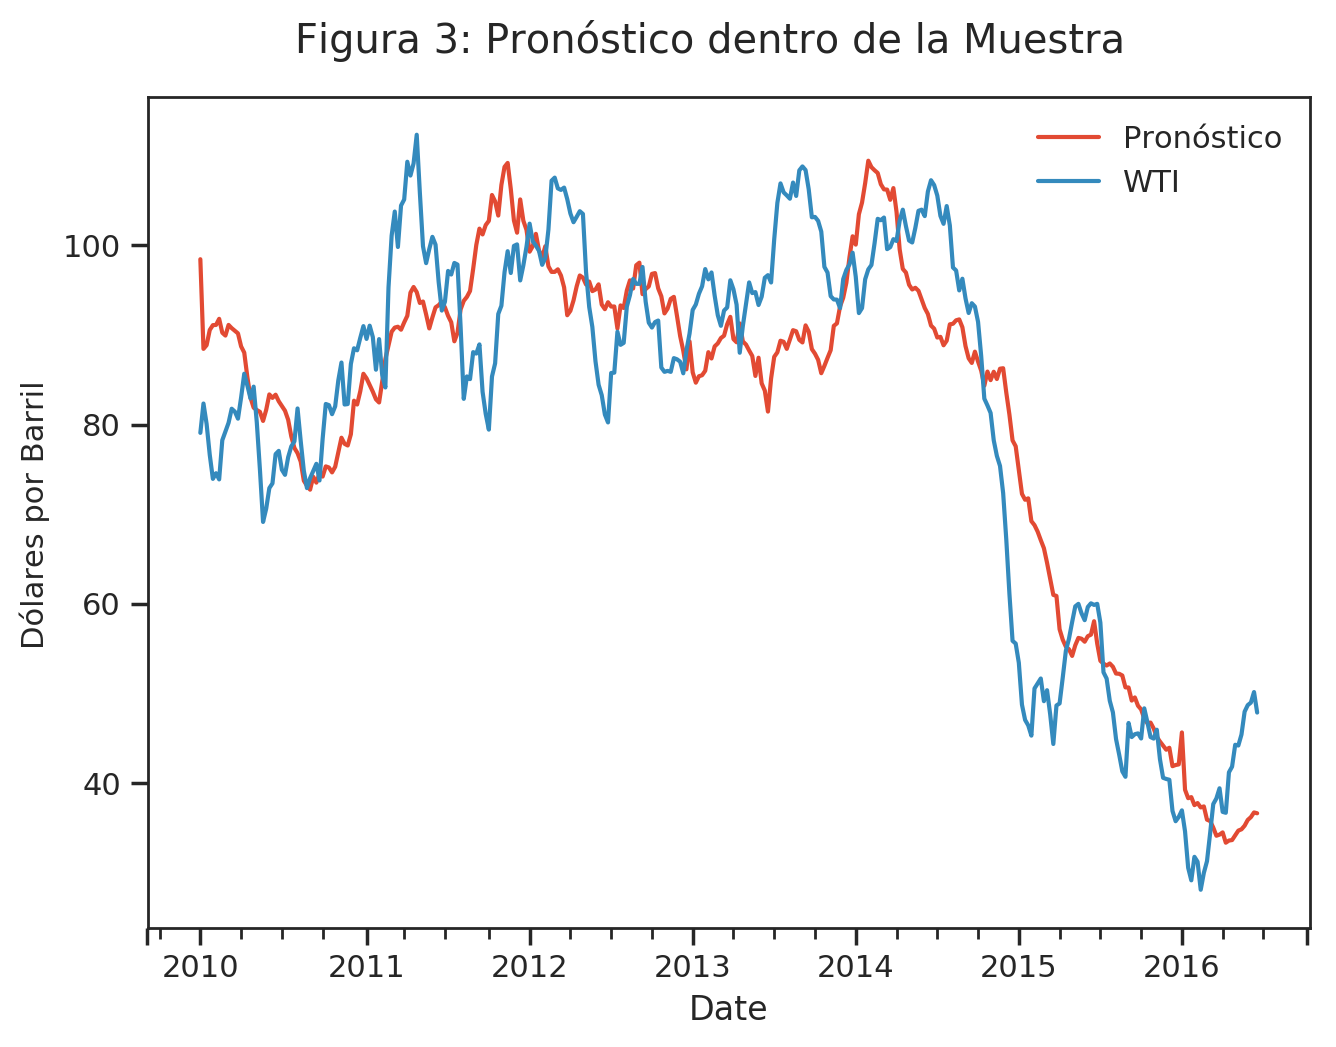

RMSE, Root Mean Square Error: 9.545
MSE, Mean Square Error: 91.106
PearsonR Correlation Coefficient: 0.9
R2, Coefficient of Determination: 0.81


In [20]:
# In-Sample
sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=100)
plt.suptitle('Figura 3: Pronóstico dentro de la Muestra', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax = train['TrainForecast'].plot(label='Pronóstico')
ax = train['WTI'].plot(label='WTI')
ax = plt.gca()
plt.figtext(0.04, 0.5, 'Dólares por Barril', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
plt.show()

# Measure differences between prediction & observed value
RMSEtrain = (((train['TrainForecast'] - train['WTI']) ** 2).mean() ** .5)
MSEtrain = ((train['TrainForecast'] - train['WTI']) ** 2).mean()
CORRtrain = train['TrainForecast'].corr(train['WTI'])
R2train = (train['TrainForecast'].corr(train['WTI'])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtrain,3))
print("MSE, Mean Square Error:", round(MSEtrain,3))
print("PearsonR Correlation Coefficient:", round(CORRtrain,3))
print("R2, Coefficient of Determination:", round(R2train,3))

La figura 3,  refleja el pronóstico a largo plazo y el precio spot del WTI para el período dentro de la muestra. En el eje vertical, el precio al contado del WTI se muestra en dólares estadounidenses por barril.

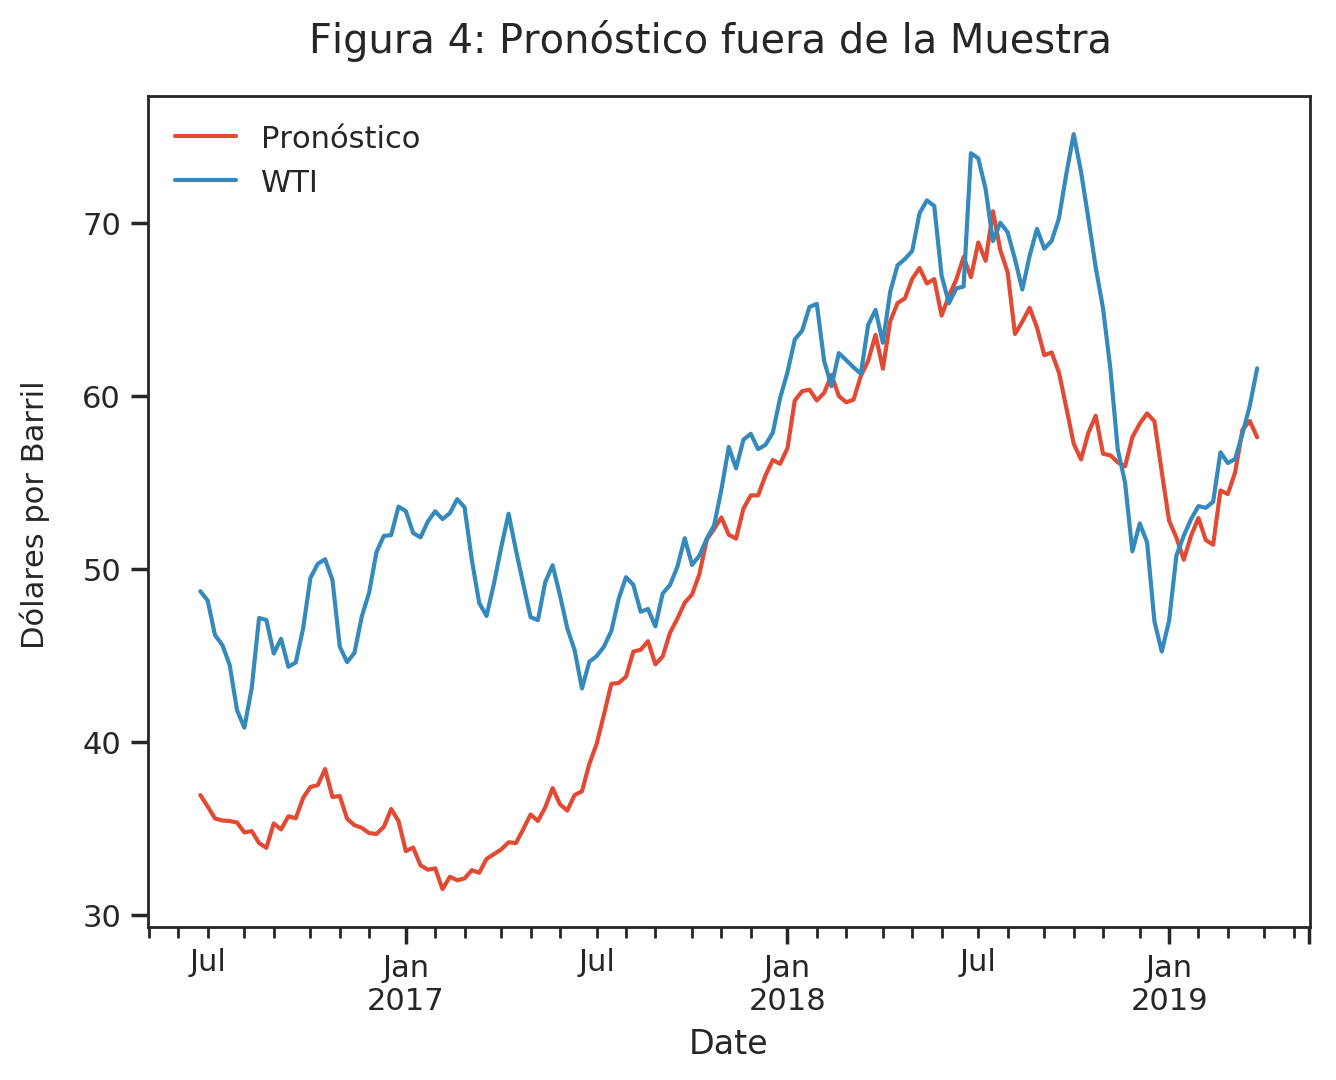

RMSE, Root Mean Square Error: 9.523
MSE, Mean Square Error: 90.689
PearsonR Correlation Coefficient: 0.835
R2, Coefficient of Determination: 0.697


In [21]:
# Out-Of-Sample
sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=100)
plt.suptitle('Figura 4: Pronóstico fuera de la Muestra', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax = test['TestForecast'].plot(label='Pronóstico')
ax = test['WTI'].plot(label='WTI')
ax = plt.gca()
plt.figtext(0.04, 0.5, 'Dólares por Barril', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
plt.show()

RMSEtest = (((test['TestForecast'] - test['WTI']) ** 2).mean() ** .5)
MSEtest = ((test['TestForecast'] - test['WTI']) ** 2).mean()
CORRtest = test['TestForecast'].corr(test['WTI'])
R2test = (test['TestForecast'].corr(test['WTI'])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtest,3))
print("MSE, Mean Square Error:", round(MSEtest,3))
print("PearsonR Correlation Coefficient:", round(CORRtest,3))
print("R2, Coefficient of Determination:", round(R2test,3))

La Figura 4, ilustra el pronóstico a largo plazo y el precio spot del WTI para el período fuera de la muestra. En el eje vertical, el precio al contado del WTI se muestra en dólares estadounidenses por barril.

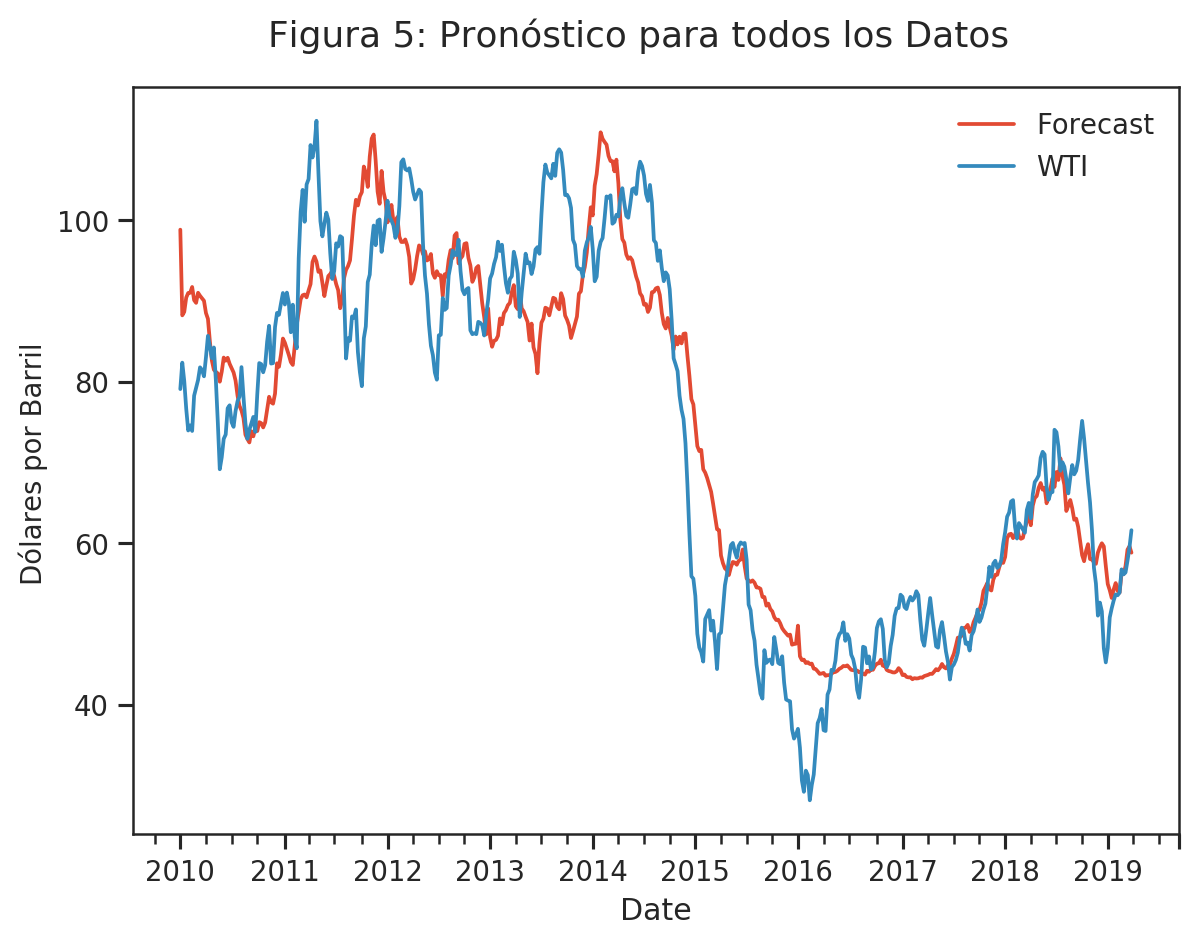

RMSE, Root Mean Square Error: 8.721
MSE, Mean Square Error: 76.061
PearsonR Correlation Coefficient: 0.921
R2, Coefficient of Determination: 0.847


In [22]:
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
sns.set_style("ticks")
plt.suptitle('Figura 5: Pronóstico para todos los Datos', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax1 = df['Forecast'].plot(label='Forecast')
ax1 = df['WTI'].plot(secondary_y=False, label='WTI')
ax1 = plt.gca()
plt.figtext(0.04, 0.5, 'Dólares por Barril', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
sns.set_style("white")
plt.show()

df['lag_wti']= df['WTI'].shift(1) 

RMSE = (((df['Forecast'] - df['WTI']) ** 2).mean() ** .5)
MSE = ((df['Forecast'] - df['WTI']) ** 2).mean()
CORR = df['Forecast'].corr(df['WTI'])
R2 = (df['Forecast'].corr(df['WTI'])**2)

print("RMSE, Root Mean Square Error:", round(RMSE,3))
print("MSE, Mean Square Error:", round(MSE,3))
print("PearsonR Correlation Coefficient:", round(CORR,3))
print("R2, Coefficient of Determination:", round(R2,3))

La Figura 5 refleja el pronóstico a largo plazo y el precio spot del WTI para toda la muestra al día de hoy. En el eje vertical, el precio al contado del WTI se muestra en dólares estadounidenses por barril.

In [23]:
print(round(df[['WTI', 'Forecast', 'RIN', 'Inventory']].tail(5),3))  

print("")

print("La tabla muestra los cinco últimos valores pronosticados generados por el pronóstico a largo plazo.")
print("En este momento, el pronóstico a largo plazo sugiere un valor razonable de", round(df.ix[-1,'Forecast'], 2), "Dólares por Barril para el precio WTI.") 

if df.ix[-1,'Forecast'] > df.ix[-1,'WTI']:
     print("El valor pronosticado es", round((df.ix[-1,'Forecast'] - df.ix[-1,'WTI']),2), "dólares por barril por encima del precio spot semanal promedio del WTI")    
else:
     print("El valor pronosticado es", round((df.ix[-1,'WTI'] - df.ix[-1,'Forecast']),2), "dólares por barril por encima del precio spot semanal promedio del WTI.")
     

              WTI  Forecast    RIN  Inventory
Date                                         
2019-03-01  56.12    56.131  0.035  1893831.0
2019-03-08  56.35    57.143  0.031  1883619.0
2019-03-15  57.81    59.184  0.025  1870977.0
2019-03-22  59.44    59.600  0.024  1871038.0
2019-03-29  61.59    58.810  0.026  1878254.0

La tabla muestra los cinco últimos valores pronosticados generados por el pronóstico a largo plazo.
En este momento, el pronóstico a largo plazo sugiere un valor razonable de 58.81 Dólares por Barril para el precio WTI.
El valor pronosticado es 2.78 dólares por barril por encima del precio spot semanal promedio del WTI.


### Rolling Correlation

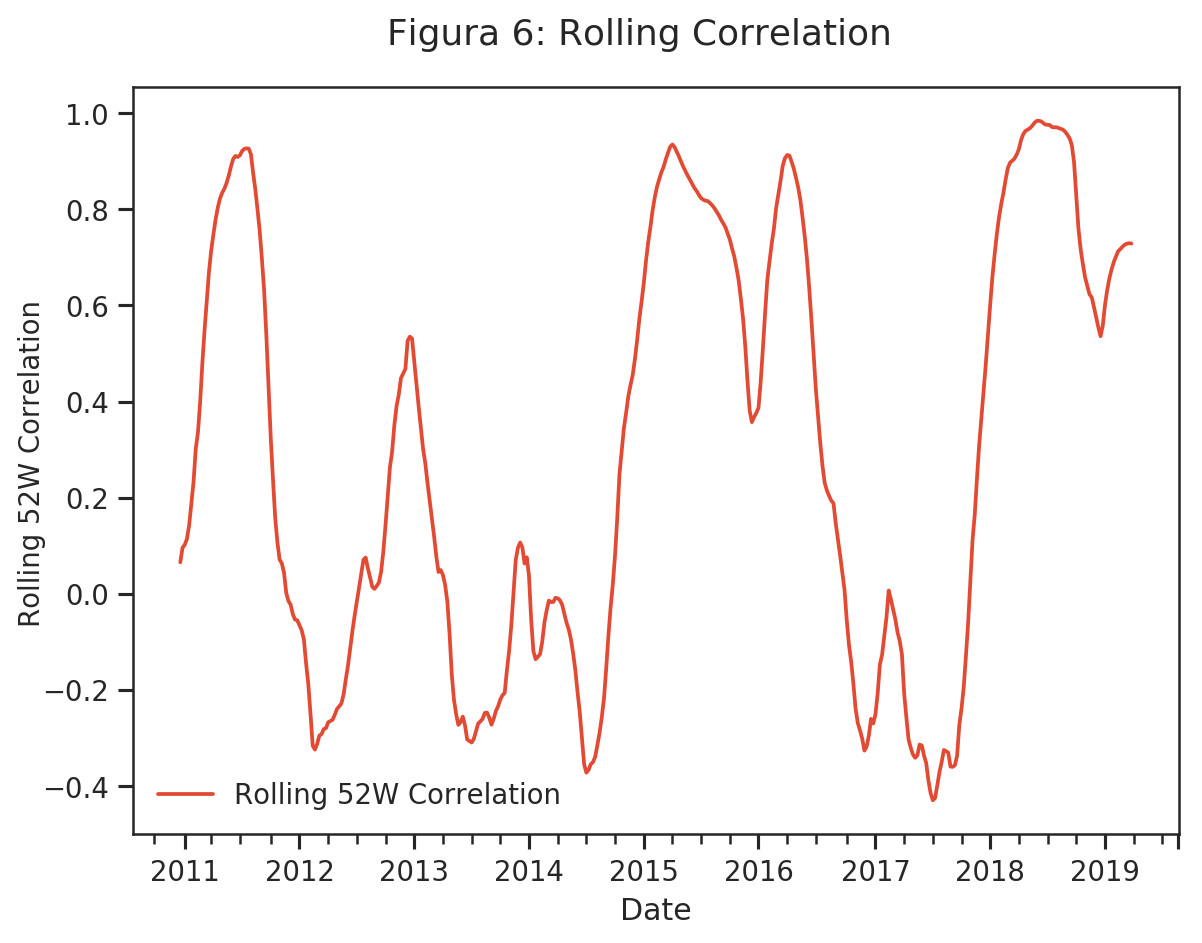

In [25]:
df['corr'] = df['WTI'].rolling(window=52).corr(df['Forecast'])
df['rollingmean'] = pd.Series.rolling(df['Forecast'], window=20).mean()
df['STD'] = pd.Series.rolling(df['WTI'], window=52).std()

fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
sns.set_style("ticks")
plt.suptitle('Figura 6: Rolling Correlation', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax1 = df['corr'].plot(label='Rolling 52W Correlation')
# ax2 = df20['STD'].plot(secondary_y=True, label='WTI Standard Deviation')
plt.figtext(0.04, 0.5, 'Rolling 52W Correlation', va='center', rotation='vertical', fontsize=11)
# plt.figtext(1.005, 0.5, 'Standard Deviation', va='center', rotation='vertical', fontsize=11)
ax2 = plt.gca()

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()
plt.legend(loc=3, frameon=False)
#plt.legend(h1+h2, l1+l2, loc=2, frameon=False)
plt.show()

### Basado en 
Michael Yea, John Zyren, Mehrzad Zamani, Antonio Merino, Álvaro Ortiz, Michael Bodell, Art Berman, Jeff Currie

### Conclusiones

Este modelo de pronóstico a largo plazo utiliza los mínimos cuadrados ordinarios (OLS) con buenos resultados, no obstante no se recomienda su uso para el pronóstico de series de tiempo a corto plazo debido a:

1- Al utilizar un ARIMA, el modelo propuesto históricamente ha sido capaz de superar a un modelo de pronóstico ingenuo en el corto plazo. Sin embargo es claro que el rendimiento pasado no es indicativo de rendimientos futuros.

1- El modelo de regresión lineal clásico se basa en el supuesto de observaciones independientes e idénticamente distribuidas. Para los datos de corte transversal, la independencia entre las observaciones se cumple automáticamente cuando se utiliza el muestreo aleatorio. Para series de tiempo, uno no puede suponer que las muestras que se toman a lo largo del tiempo son independientes entre sí. Las series de tiempo tienden a contener un alto grado de autocorrelación, particularmente en el caso de que el intervalo de muestreo sea pequeño, como una semana o un mes. Además, los datos de series de tiempo tienden a ser no estacionarios en niveles, lo que viola el requisito de observación distribuida de manera idéntica. Al emplear un modelo de regresión lineal clásico para datos de series de tiempo, el riesgo de producir un modelo espurio es alto porque no se toma suficiente cuidado durante la formulación de la estructura de autocorrelación y la no estacionaridad de los datos.